In [ ]:
import json
import pandas as pd
from collections import defaultdict
import itertools
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
import pickle
import os
from collections import defaultdict
import re
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import defaultdict
!pip install openai
from openai import OpenAI
from google.colab import userdata
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
with open('./data/politics_users_profile_api2.json', 'r', encoding='utf-8') as file:
    politics_users_profile = json.load(file)
with open('./data/events_details.json', 'r', encoding='utf-8') as file:
    Polymarket_events_details = json.load(file)
with open('./data/markets_user_data_all.json', 'r', encoding='utf-8') as file:
    all_users_overview = json.load(file)
with open('./data/Categories.json', 'r', encoding='utf-8') as file: 
    data_categories = json.load(file)

# Pre-process

In [3]:
# Createdate
id_to_creationTimestamp = {user["id"]: user["creationTimestamp"] for user in all_users_overview}

for user, details in politics_users_profile.items():
    createdAt = details["profile"].get("createdAt")
    if createdAt:
        timestamp = datetime.strptime(createdAt, "%Y-%m-%dT%H:%M:%S.%fZ").timestamp()
        details["profile"]["createdAt"] = str(int(timestamp))
    else:
        proxyWallet = details["profile"].get("proxyWallet")
        if proxyWallet in id_to_creationTimestamp:
            details["profile"]["createdAt"] = id_to_creationTimestamp[proxyWallet]
        else:
            activities = details.get("activities", [])
            if activities:
                earliest_timestamp = min(activity["timestamp"] for activity in activities if "timestamp" in activity)
                details["profile"]["createdAt"] = str(earliest_timestamp)

# Calculate activities numbers
for user, details in politics_users_profile.items():
    details["activityNum"] = len(details["activities"])

# Remove activities where type is not "TRADE"
for user, details in politics_users_profile.items():
    details["activities"] = [activity for activity in details["activities"] if activity["type"] == "TRADE"]

# Remove users with 0 activities
politics_users_profile = {
    profile_url: profile_data
    for profile_url, profile_data in politics_users_profile.items()
    if profile_data['activities']
}

# Obtain category id
condition_to_category = {}  # conditionId - categories

for event_url, event_details in Polymarket_events_details.items():
    queries = event_details["props"]["pageProps"]["dehydratedState"]["queries"]
    for query in queries:
        data = query["state"]["data"]
        if "markets" in data and "categories" in data:
            categories = data["categories"]
            for market in data["markets"]:
                conditionId = market["conditionId"]

                if categories:
                    condition_to_category[conditionId] = {
                        "categoryID": categories[0]["id"],
                        "parentCategoryID": categories[0]["parentCategory"]
                    }

for user, details in politics_users_profile.items():
    for activity in details["activities"]:
        conditionId = activity["conditionId"]

        # resrch conditionId
        if conditionId in condition_to_category:
            activity.update(condition_to_category[conditionId])
        else:
            activity["categoryID"] = 0
            activity["parentCategoryID"] = 0

## Fine-tuning

In [4]:
# Fine-tuning to add missed categoryID
data_items = []

for user, details in politics_users_profile.items():
    for activity in details['activities']:
        if activity['categoryID'] != 0:
            title = activity['title']
            category_id = str(activity['categoryID'])
            if (title, category_id) not in data_items:
                data_items.append((title, category_id))


titles, categories = zip(*data_items)
titles_train, titles_val, categories_train, categories_val = train_test_split(
    titles, categories, test_size=0.2, random_state=42
)
# train 4877
with open('./data/temp/training_data.jsonl', 'w', encoding='utf-8') as file:
    for title, category in zip(titles_train, categories_train):
        line = {"prompt": title, "completion": category}
        file.write(json.dumps(line) + '\n')

# valid 1220
with open('./data/temp/validation_data.jsonl', 'w', encoding='utf-8') as file:
    for title, category in zip(titles_val, categories_val):
        line = {"prompt": title, "completion": category}
        file.write(json.dumps(line) + '\n')

In [ ]:
client = OpenAI(api_key=userdata.get('gpt')) # change to your API key

client.files.create(
  file=open("./data/temp/training_data.jsonl", "rb"),
  purpose="fine-tune"
)

client.files.create(
  file=open("./data/temp/validation_data.jsonl", "rb"),
  purpose="fine-tune"
)

client.fine_tuning.jobs.create(
  training_file="file-id", # change to your file ID
  validation_file ="file-id", # change to your file ID
  model="babbage-002" 
)

In [ ]:
job_id = "ftjob-id" # change to your job ID

job = client.fine_tuning.jobs.retrieve(job_id)
print(f"Job status: {job.status}")
if job.status == 'failed':
    print(f"Error message: {job.error.message}")
if job.status == 'succeeded':
    fine_tune_results = client.fine_tuning.jobs.retrieve(job_id).result_files
    result_file = client.files.retrieve(fine_tune_results[0])
    content = client.files.content(result_file.id)
    # save content to file
    with open("./data/temp/fine_tuning_result.csv", "wb") as f:
        f.write(content.text.encode("utf-8"))

Job status: succeeded


In [ ]:
ft_model = "ft:babbage-002:personal::id" # change to your fine-tuned model ID

validation_prompts = []
actual_labels = []

with open("./data/temp/validation_data.jsonl", "r", encoding="utf-8") as file:
    for line in file:
        data = json.loads(line)
        validation_prompts.append(data["prompt"])
        actual_labels.append(data["completion"])

predicted_labels = []

for prompt in validation_prompts:
    response = client.completions.create(
        model=ft_model,
        prompt=prompt,
        max_tokens=2,  # figures like "xxxx" = 2 tokens
        n=1,
        temperature=0,
    )
    predicted_label = response.choices[0].text.strip()[:4]
    predicted_labels.append(predicted_label)

# predicted_labels is a list, save it to json
with open("./data/temp/predicted_labels.json", "w") as file:
    json.dump(predicted_labels, file)

In [ ]:
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(actual_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(actual_labels, predicted_labels, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.7426229508196721
Precision: 0.7451876071903129
Recall: 0.7426229508196721
F1 Score: 0.7252284850323334


In [ ]:
# Use fine-tuned model to supplement id
client = OpenAI(api_key=userdata.get('gpt')) # change to your API key
ft_model = "ft:babbage-002:personal::id" # change to your fine-tuned model ID
category_to_parent = {
    cat["id"]: cat.get("parentCategory", cat["id"]) for cat in data_categories
}
unique_titles_with_no_category = set()

for user, details in politics_users_profile.items():
    for activity in details["activities"]:
        if activity["categoryID"] == 0:
            unique_titles_with_no_category.add(activity['title'])

def predict_category(title, fine_tuned_model):
    response = client.completions.create(
        model=fine_tuned_model,
        prompt=title,
        max_tokens=2,
        n=1,
        temperature=0,
    )
    return response.choices[0].text.strip()[:4]

predicted_categories = {title: predict_category(title, ft_model) for title in unique_titles_with_no_category}

for user, details in politics_users_profile.items():
    for activity in details["activities"]:
        if activity["categoryID"] == 0 and activity['title'] in predicted_categories:
            predicted_cat_id = predicted_categories[activity['title']]
            # whether in categories.json
            if predicted_cat_id in category_to_parent:
                activity["categoryID"] = predicted_cat_id
                activity["parentCategoryID"] = category_to_parent[predicted_cat_id]
            else:
                activity["categoryID"] = 0
                activity["parentCategoryID"] = 0
                pass

In [ ]:
for user, details in politics_users_profile.items():
    for activity in details["activities"]:
        if activity["categoryID"] != 0 and activity["parentCategoryID"] is None:
            activity["parentCategoryID"] = activity["categoryID"]

# Political Betting Leaning Score

In [ ]:
# Extract all users who participated in the "presidential-election-winner-2024" event
users_in_event = []
for user, details in politics_users_profile.items():
    for activity in details["activities"]:
        #if activity.get("eventSlug") == "presidential-election-winner-2024":
        if activity.get("eventSlug") == "presidential-election-popular-vote-winner-2024":
            users_in_event.append((user, activity))

# Use a regular expression to extract the candidate name from the "title" field
candidate_pattern = re.compile(r"Will (.*) win the popular vote in the 2024 Presidential Election\?")

# Find all unique candidates
candidates = set()
for user, activity in users_in_event:
    title = activity["title"]
    match = candidate_pattern.match(title)
    if match:
        candidate = match.group(1)
        candidates.add(candidate)

In [4]:
democratic_candidates = [
    "Joe Biden",
    "Kamala Harris",
    "Bernie Sanders",
    "Elizabeth Warren",
    "AOC",  #Alexandria Ocasio-Cortez
    "Gavin Newsom",
    "Hillary Clinton",
    "Michelle Obama",
    'any other Democrat Politician',
    "any other Democratic Politician"
]

republican_candidates = [
    "Donald Trump",
    "Ron DeSantis",
    "Nikki Haley",
    "Chris Christie",
    "Vivek Ramaswamy",
    "Kanye West",
    "any other Republican Politician"
]


def get_candidate_party(title):
    for candidate in democratic_candidates:
        if candidate in title:
            return 1
    for candidate in republican_candidates:
        if candidate in title:
            return -1
    return 0

def calculate_political_leaning_score(user_transactions, market, alpha=0.5, theta=0.005, half_life=14):
    democratic_weight = 0
    republican_weight = 0
    total_amount = 0
    trade_count = 0
    has_election_transaction = False

    market_start_time = datetime.strptime('2024-01-04T22:58:15.194', '%Y-%m-%dT%H:%M:%S.%f')
    market_end_time = datetime.strptime('2024-11-05T00:00:00.000', '%Y-%m-%dT%H:%M:%S.%f')
    market_mid_time = market_start_time + (market_end_time - market_start_time) / 2

    for transaction in user_transactions:
        if transaction['eventSlug'] == market:
            has_election_transaction = True
            trade_count += 1
            transaction_time = datetime.fromtimestamp(transaction['timestamp'])
            price = transaction['price']
            amount = transaction['usdcSize']
            candidate_party = get_candidate_party(transaction['title'])

            if abs(price - 0.5) <= 0.5 - theta:
                price_weight = abs(price - 0.5) / 0.5  # 0.5 might be just guess
                time_decay = np.exp(-np.log(2) / half_life * (market_end_time - transaction_time).days)
                amount_weight = np.log(1 + amount) if transaction['side'] == 'BUY' else -np.log(1 + amount)
                party_weight = candidate_party * (1 if transaction['outcomeIndex'] == 0 else -1)


                weight = price_weight * time_decay * amount_weight * party_weight

                if candidate_party > 0:
                    democratic_weight += weight
                elif candidate_party < 0:
                    republican_weight += weight

                total_amount += abs(weight)

    frequency_weight = np.log(1 + trade_count)

    if total_amount > 0:
        political_leaning_score = frequency_weight * (democratic_weight - republican_weight) / total_amount
    else:
        political_leaning_score = -99

    return political_leaning_score

market = 'presidential-election-winner-2024'

for user, details in politics_users_profile.items():
      political_leaning_score = calculate_political_leaning_score(details["activities"], market)
      details["political_leaning_score"] = political_leaning_score

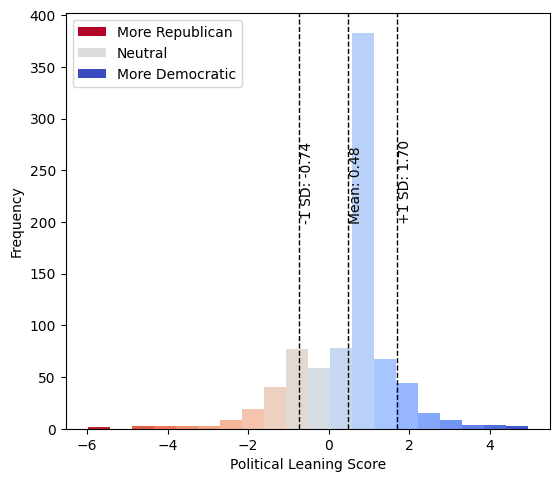

In [5]:
from matplotlib.colors import LinearSegmentedColormap

valid_scores = [details["political_leaning_score"] for user, details in politics_users_profile.items() if details["political_leaning_score"] != -99]

counts, bin_edges = np.histogram(valid_scores, bins=20, density=False)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# statistics
weighted_mean = np.average(bin_centers, weights=counts)

mean_diff_sq = (bin_centers - weighted_mean) ** 2
weighted_var = np.average(mean_diff_sq, weights=counts)
weighted_std = np.sqrt(weighted_var)

cmap = plt.get_cmap('coolwarm')
norm = plt.Normalize(min(valid_scores), max(valid_scores))
colors = cmap(1.0 - norm(bin_centers))

plt.figure(figsize=(6.25, 5.4))
for (color, count, bin_center) in zip(colors, counts, bin_centers):
    plt.bar(bin_center, count, width=np.diff(bin_edges)[0], color=color)

text_offset = 0.02
plt.axvline(weighted_mean, color='k', linestyle='dashed', linewidth=1)
plt.text(weighted_mean + text_offset, plt.ylim()[1] * 0.5, f'Mean: {weighted_mean:.2f}', rotation=90)

plt.axvline(weighted_mean + weighted_std, color='k', linestyle='dashed', linewidth=1)
plt.text(weighted_mean + weighted_std + text_offset, plt.ylim()[1] * 0.5, f'+1 SD: {(weighted_mean + weighted_std):.2f}', rotation=90)

plt.axvline(weighted_mean - weighted_std, color='k', linestyle='dashed', linewidth=1)
plt.text(weighted_mean - weighted_std + text_offset, plt.ylim()[1] * 0.5, f'-1 SD: {(weighted_mean - weighted_std):.2f}', rotation=90)

plt.xlim(min(bin_centers) - (max(bin_centers) - min(bin_centers)) * 0.08,
         max(bin_centers) + (max(bin_centers) - min(bin_centers)) * 0.08)

plt.xlabel('Political Leaning Score')
plt.ylabel('Frequency')


legend_elements = [Patch(facecolor=cmap(1.0), label='More Republican'),
                   Patch(facecolor=cmap(0.5), label='Neutral'),
                   Patch(facecolor=cmap(0.0), label='More Democratic')]
plt.legend(handles=legend_elements)
plt.savefig('./figure/PLS_distribution_800.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [ ]:
with open('./data/temp/politics_users_profile_api2++.json', 'w', encoding='utf-8') as file: 
    json.dump(politics_users_profile, file, ensure_ascii=False, indent=2)

## Internal Validation - popular vote

In [40]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr, f_oneway, ks_2samp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import json
from scipy.stats import t
from scipy.stats import norm

In [ ]:
with open('./data/temp/politics_users_profile_api2++.json', 'r', encoding='utf-8') as file:
    politics_users_profile = json.load(file)

market = 'presidential-election-popular-vote-winner-2024'

for user, details in politics_users_profile.items():
      political_leaning_score = calculate_political_leaning_score(details["activities"], market) # calculate PBLS on the popular vote market
      details["political_leaning_score_val"] = political_leaning_score

with open('./data/temp/politics_users_profile_api2++popular.json', 'w', encoding='utf-8') as file: 
    json.dump(politics_users_profile, file, ensure_ascii=False, indent=2)

In [ ]:
def compare_pls_scores(politics_users_profile):
    pls_scores = []
    pls2_scores = []
    user_in_both_markets = 0
    user_only_in_election_market = 0
    user_only_in_popular_vote_market = 0

    for user, details in politics_users_profile.items():
        if details['political_leaning_score'] != -99:
            pls_scores.append(details['political_leaning_score'])
            if details['political_leaning_score_val'] != -99:
                user_in_both_markets += 1
            else:
                user_only_in_election_market += 1
        if details['political_leaning_score_val'] != -99:
            pls2_scores.append(details['political_leaning_score_val'])
            if details['political_leaning_score'] == -99:
                user_only_in_popular_vote_market += 1

    print(f"Number of PLS (in election market): {len(pls_scores)}")
    print(f"Number of PLS2 (in popular vote market): {len(pls2_scores)}")
    print(f"Number of in both markets: {user_in_both_markets}")

    print(f"PLS mean: {np.mean(pls_scores)}, PLS2 mean: {np.mean(pls2_scores)}")
    print(f"PLS std: {np.std(pls_scores)}, PLS2 std: {np.std(pls2_scores)}")
    print(f"Kolmogorov-Smirnov test p-value: {ks_2samp(pls_scores, pls2_scores).pvalue}")

    user_scores = pd.DataFrame({'User': [user for user, details in politics_users_profile.items() if details['political_leaning_score'] != -99 and details['political_leaning_score_val'] != -99],
                                'PLS': [details['political_leaning_score'] for user, details in politics_users_profile.items() if details['political_leaning_score'] != -99 and details['political_leaning_score_val'] != -99],
                                'PLS2': [details['political_leaning_score_val'] for user, details in politics_users_profile.items() if details['political_leaning_score'] != -99 and details['political_leaning_score_val'] != -99]})

    user_scores.to_csv('user_scores.csv', index=False)

    pearson_corr, pearson_p = pearsonr(user_scores['PLS'], user_scores['PLS2'])
    spearman_corr, spearman_p = spearmanr(user_scores['PLS'], user_scores['PLS2'])

    print(f"PLS-PLS2 Pearson correlation: {pearson_corr}, p-value: {pearson_p}")
    print(f"PLS-PLS2 Spearman correlation: {spearman_corr}, p-value: {spearman_p}")

compare_pls_scores(politics_users_profile)

Number of PLS (in election market): 823
Number of PLS2 (in popular vote market): 142
Number of in both markets: 106
PLS mean: 0.48043067184016397, PLS2 mean: 0.2525345324104643
PLS std: 1.205136044978032, PLS2 std: 1.3504249869032396
Kolmogorov-Smirnov test p-value: 0.059927621073042794
PLS-PLS2 Pearson correlation: 0.626948521764074, p-value: 6.49301241547721e-13
PLS-PLS2 Spearman correlation: 0.5340011145936772, p-value: 3.750173406699545e-09


## External validation - polls

In [47]:
poll_df = pd.read_excel('./data/president_polls.xlsx') # download from ABC News

poll_agg = poll_df.pivot_table(index='poll_id', columns='party', values='pct', aggfunc='mean')
poll_agg['dem_rep_ratio'] = poll_agg['DEM'] / poll_agg['REP']

poll_sizes = poll_df.groupby('poll_id')['sample_size'].first()
poll_agg['sample_size'] = poll_sizes
poll_agg = poll_agg.reset_index()

#poll_agg drop nan
poll_agg = poll_agg.dropna()

pls_scores = []
for user, details in politics_users_profile.items():
    if details['political_leaning_score'] != -99:
        pls_scores.append(details['political_leaning_score'])

dem_count = 0
rep_count = 0
mean = 0.48
sd = 1.22

for score in pls_scores:
    if score > mean + sd:
        dem_count += 1
    elif score < mean - sd:
        rep_count += 1

pbls_ratio = dem_count / rep_count

In [48]:
n_bootstraps = 1000
bootstrap_ratios = []

for _ in range(n_bootstraps):
    sample_ids = np.random.choice(poll_agg['poll_id'], size=len(poll_agg), replace=True, p=poll_agg['sample_size'] / poll_agg['sample_size'].sum())
    sample_df = poll_agg[poll_agg['poll_id'].isin(sample_ids)]
    sample_ratio = np.average(sample_df['dem_rep_ratio'], weights=sample_df['sample_size'])
    bootstrap_ratios.append(sample_ratio)

bootstrap_ratios = np.array(bootstrap_ratios)
ratio_mean = np.mean(bootstrap_ratios)
ratio_std = np.std(bootstrap_ratios)

ci_lower = ratio_mean + norm.ppf(0.025) * ratio_std
ci_upper = ratio_mean + norm.ppf(0.975) * ratio_std

print(f"Weighted Mean of Dem/Rep ratio in polls: {ratio_mean:.3f}")
print(f"Dem/Rep ratio according to PBLS: {pbls_ratio:.3f}")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")

if ci_lower <= pbls_ratio <= ci_upper:
    print("PBLS ratio falls within the 95% CI of poll ratios.")
else:
    print("PBLS ratio falls outside the 95% CI of poll ratios.")

Weighted Mean of Dem/Rep ratio in polls: 1.216
Dem/Rep ratio according to PBLS: 0.760
95% CI: [0.703, 1.729]
PBLS ratio falls within the 95% CI of poll ratios.


# Feature Engineering and Correlation Analysis

In [ ]:
import pandas as pd
from collections import defaultdict
import json
from scipy import stats
from datetime import datetime
import numpy as np

In [ ]:
with open('./data/temp/politics_users_profile_api2++popular.json', 'r', encoding='utf-8') as file:
    politics_users_profile = json.load(file)
with open('./data/events_details_clip.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

In [ ]:
market_outcomes = {}
for slug, market_data in data.items():
    resolution_price = market_data.get('resolutionPrice')
    if resolution_price == '1000000000000000000':
        market_outcomes[slug] = 'Yes'
    elif resolution_price == '0':
        market_outcomes[slug] = 'No'

def extract_features(user_data):
    features = {}

    # 1 Basic features
    data_collection_date = datetime(2024, 2, 28)
    created_at = datetime.fromtimestamp(int(user_data['profile']['createdAt']))
    features['days_since_created'] = (data_collection_date - created_at).days
    total_profit = 0
    total_realized_profit = 0
    events_traded = set()
    markets_traded = set()
    total_volume = 0

    for activity in user_data['activities']:
        if activity['categoryID'] != 0:
            total_profit += activity['usdcSize'] * (1 if activity['side'] == 'SELL' else -1)
            if activity['side'] == 'SELL':
                total_realized_profit += activity['usdcSize']
            events_traded.add(activity['eventSlug'])
            markets_traded.add(activity['slug'])
            total_volume += activity['usdcSize']

    features['totalProfit'] = total_profit
    features['realized'] = total_realized_profit
    features['eventsTraded'] = len(events_traded)
    features['marketsTraded'] = len(markets_traded)
    features['volumeTraded'] = total_volume
    features['activityNum'] = len(user_data['activities'])

    # 2 The counts and proportion
    market_types = defaultdict(int)
    parent_market_types = defaultdict(int)
    for activity in user_data['activities']:
        if activity['categoryID'] != 0:
            market_types[activity['categoryID']] += 1
            parent_market_types[activity['parentCategoryID']] += 1
    total_activities = len(user_data['activities'])

    for market_type, count in market_types.items():
        features[f'market_type_{market_type}_count'] = count
        features[f'market_type_{market_type}_ratio'] = count / total_activities
    for parent_type, count in parent_market_types.items():
        features[f'parent_market_type_{parent_type}_count'] = count
        features[f'parent_market_type_{parent_type}_ratio'] = count / total_activities

    # 3 Trading frequency and amount
    market_type_buy_amounts = defaultdict(float)
    market_type_sell_amounts = defaultdict(float)
    market_type_buy_counts = defaultdict(int)
    market_type_sell_counts = defaultdict(int)

    parent_market_buy_amounts = defaultdict(float)
    parent_market_sell_amounts = defaultdict(float)
    parent_market_buy_counts = defaultdict(int)
    parent_market_sell_counts = defaultdict(int)

    for activity in user_data['activities']:
        if activity['categoryID'] != 0:
            if activity['side'] == 'BUY':
                market_type_buy_amounts[activity['categoryID']] += activity['usdcSize']
                market_type_buy_counts[activity['categoryID']] += 1

                parent_market_buy_amounts[activity['parentCategoryID']] += activity['usdcSize']
                parent_market_buy_counts[activity['parentCategoryID']] += 1
            else:
                market_type_sell_amounts[activity['categoryID']] += activity['usdcSize']
                market_type_sell_counts[activity['categoryID']] += 1

                parent_market_sell_amounts[activity['parentCategoryID']] += activity['usdcSize']
                parent_market_sell_counts[activity['parentCategoryID']] += 1

    for market_type in market_types:
        features[f'market_type_{market_type}_buy_amount'] = market_type_buy_amounts[market_type]
        features[f'market_type_{market_type}_sell_amount'] = market_type_sell_amounts[market_type]
        features[f'market_type_{market_type}_amount'] = market_type_buy_amounts[market_type] + market_type_sell_amounts[market_type]
        features[f'market_type_{market_type}_buy_frequency'] = market_type_buy_counts[market_type] / market_types[market_type]
        features[f'market_type_{market_type}_sell_frequency'] = market_type_sell_counts[market_type] / market_types[market_type]

    for parent_type in parent_market_types:
        features[f'parent_market_type_{parent_type}_buy_amount'] = parent_market_buy_amounts[parent_type]
        features[f'parent_market_type_{parent_type}_sell_amount'] = parent_market_sell_amounts[parent_type]
        features[f'parent_market_type_{parent_type}_amount'] = parent_market_buy_amounts[parent_type] + parent_market_sell_amounts[parent_type]
        features[f'parent_market_type_{parent_type}_buy_frequency'] = parent_market_buy_counts[parent_type] / parent_market_types[parent_type] if parent_market_types[parent_type] > 0 else None
        features[f'parent_market_type_{parent_type}_sell_frequency'] = parent_market_sell_counts[parent_type] / parent_market_types[parent_type] if parent_market_types[parent_type] > 0 else None

    # 4 success rate and P/L
    market_type_success_counts = defaultdict(int)
    market_type_profit_loss = defaultdict(float)

    parent_market_success_counts = defaultdict(int)
    parent_market_profit_loss = defaultdict(float)

    market_positions = defaultdict(lambda: {'Yes': 0, 'No': 0})

    for activity in sorted(user_data['activities'], key=lambda x: x['timestamp']):
        if activity['categoryID'] != 0:
            market_slug = activity['slug']
            market_type = activity['categoryID']
            parent_type = activity['parentCategoryID']

            outcome = 'Yes' if activity['outcomeIndex'] == 0 else 'No'

            if activity['side'] == 'BUY':
                market_positions[market_slug][outcome] += activity['size']
                market_type_profit_loss[market_type] -= activity['usdcSize']
            else:  # SELL
                market_positions[market_slug][outcome] -= activity['size']
                market_type_profit_loss[market_type] += activity['usdcSize']

    for market_slug, position in market_positions.items():
        if market_slug in market_outcomes: #market clip data
            final_outcome = market_outcomes[market_slug]
            market_type = next(activity['categoryID'] for activity in user_data['activities'] if activity['slug'] == market_slug)
            parent_type = next(activity['parentCategoryID'] for activity in user_data['activities'] if activity['slug'] == market_slug)

            if position[final_outcome] > 0:
                market_type_success_counts[market_type] += 1
                parent_market_success_counts[parent_type] += 1

            market_type_profit_loss[market_type] += position[final_outcome]
            parent_market_profit_loss[parent_type] += position[final_outcome]

    for market_type in market_type_success_counts:
        total_markets = sum(1 for activity in user_data['activities'] if activity['categoryID'] == market_type and activity['slug'] in market_outcomes)
        if total_markets > 0:
            features[f'market_type_{market_type}_success_rate'] = market_type_success_counts[market_type] / total_markets
            features[f'market_type_{market_type}_profit_loss'] = market_type_profit_loss[market_type]

    for parent_type in parent_market_success_counts:
        total_markets = sum(1 for activity in user_data['activities'] if activity['parentCategoryID'] == parent_type and activity['slug'] in market_outcomes)
        if total_markets > 0:
            features[f'parent_market_type_{parent_type}_success_rate'] = parent_market_success_counts[parent_type] / total_markets
            features[f'parent_market_type_{parent_type}_profit_loss'] = parent_market_profit_loss[parent_type]
        else:
            features[f'parent_market_type_{parent_type}_success_rate'] = None
            features[f'parent_market_type_{parent_type}_profit_loss'] = None

    # 5 holding_times and intervals
    holding_times = []
    parent_market_trade_intervals = defaultdict(list)
    prev_timestamp = defaultdict(int)
    positions = defaultdict(lambda: defaultdict(list))

    for activity in sorted(user_data['activities'], key=lambda x: x['timestamp']):
        if activity['categoryID'] != 0:
            timestamp = activity['timestamp']
            market_id = activity['eventSlug']
            parent_type = activity['parentCategoryID']
            outcome = 'Yes' if activity['outcomeIndex'] == 0 else 'No'

            if activity['side'] == 'BUY':
                positions[market_id][outcome].append((timestamp, activity['size']))
            else:  # SELL
                if positions[market_id][outcome]:
                    buy_time, buy_size = positions[market_id][outcome].pop(0)
                    holding_times.append((timestamp - buy_time) / 86400)  # Convert to days

            if prev_timestamp[parent_type] != 0:
                parent_market_trade_intervals[parent_type].append((timestamp - prev_timestamp[parent_type]) / 86400)  # Convert to days
            prev_timestamp[parent_type] = timestamp

    for market_id in positions:
        for outcome in positions[market_id]:
            for buy_time, buy_size in positions[market_id][outcome]:
                holding_times.append((data_collection_date.timestamp() - buy_time) / 86400)  # Convert to days

    if holding_times:
        features['median_holding_time'] = np.median(holding_times)
    else:
        features['median_holding_time'] = None

    for parent_type in parent_market_types:
        if parent_market_trade_intervals[parent_type]:
            features[f'median_trade_interval_parent_{parent_type}'] = np.median(parent_market_trade_intervals[parent_type])
        else:
            features[f'median_trade_interval_parent_{parent_type}'] = None

    # 6 Before/ after specific events
    midterm_election_date = datetime(2022, 11, 8).timestamp()
    presidential_election_market_open_date = datetime(2024, 1, 4).timestamp()

    pre_midterm_activities = [activity for activity in user_data['activities'] if activity['timestamp'] < midterm_election_date]
    post_midterm_activities = [activity for activity in user_data['activities'] if activity['timestamp'] >= midterm_election_date]

    pre_market_open_activities = [activity for activity in user_data['activities'] if activity['timestamp'] < presidential_election_market_open_date]
    post_market_open_activities = [activity for activity in user_data['activities'] if activity['timestamp'] >= presidential_election_market_open_date]

    features['pre_midterm_activity_count'] = len(pre_midterm_activities)
    features['post_midterm_activity_count'] = len(post_midterm_activities)
    features['pre_midterm_avg_amount'] = sum(activity['usdcSize'] for activity in pre_midterm_activities) / len(pre_midterm_activities) if pre_midterm_activities else None
    features['post_midterm_avg_amount'] = sum(activity['usdcSize'] for activity in post_midterm_activities) / len(post_midterm_activities) if post_midterm_activities else None

    features['pre_market_open_activity_count'] = len(pre_market_open_activities)
    features['post_market_open_activity_count'] = len(post_market_open_activities)
    features['pre_market_open_avg_amount'] = sum(activity['usdcSize'] for activity in pre_market_open_activities) / len(pre_market_open_activities) if pre_market_open_activities else None
    features['post_market_open_avg_amount'] = sum(activity['usdcSize'] for activity in post_market_open_activities) / len(post_market_open_activities) if post_market_open_activities else None

    # 7 Side preference
    for market_type in market_types:
        market_type_yes_amount = sum(activity['usdcSize'] for activity in user_data['activities'] if activity['categoryID'] == market_type and activity['outcomeIndex'] == 0)
        market_type_no_amount = sum(activity['usdcSize'] for activity in user_data['activities'] if activity['categoryID'] == market_type and activity['outcomeIndex'] == 1)
        features[f'market_type_{market_type}_yes_ratio'] = market_type_yes_amount / (market_type_yes_amount + market_type_no_amount) if (market_type_yes_amount + market_type_no_amount) > 0 else None
        features[f'market_type_{market_type}_no_ratio'] = market_type_no_amount / (market_type_yes_amount + market_type_no_amount) if (market_type_yes_amount + market_type_no_amount) > 0 else None

    for parent_type in parent_market_types:
        parent_type_yes_amount = sum(activity['usdcSize'] for activity in user_data['activities'] if activity['parentCategoryID'] == parent_type and activity['outcomeIndex'] == 0)
        parent_type_no_amount = sum(activity['usdcSize'] for activity in user_data['activities'] if activity['parentCategoryID'] == parent_type and activity['outcomeIndex'] == 1)
        total_amount = parent_type_yes_amount + parent_type_no_amount
        features[f'parent_market_type_{parent_type}_yes_ratio'] = parent_type_yes_amount / total_amount if total_amount > 0 else None
        features[f'parent_market_type_{parent_type}_no_ratio'] = parent_type_no_amount / total_amount if total_amount > 0 else None

    # 8 Risk preference
    total_trades = len(user_data['activities']) #user_data['activityNum']
    total_volume = total_volume #user_data['volumeTraded']

    avg_price_diff = []
    volume_ratio = []

    for activity in user_data['activities']:
        if activity['categoryID'] != 0 and total_volume >0 and 0 <= activity['price'] <= 1:
            avg_price_diff.append(abs(activity['price'] - 0.5))  #comparing with 0.5
            volume_ratio.append(activity['usdcSize'] / total_volume)

    if avg_price_diff:
        features['avg_price_diff'] = np.mean(avg_price_diff)
        features['vol_weighted_avg_price_diff'] = np.average(avg_price_diff, weights=volume_ratio)
    else:
        features['avg_price_diff'] = None
        features['vol_weighted_avg_price_diff'] = None

    market_type_count = len({activity['categoryID'] for activity in user_data['activities'] if activity['categoryID'] != 0})
    features['market_type_concentration'] = market_type_count / total_trades if total_trades > 0 else None

    parent_market_type_count = len(parent_market_types)
    features['parent_market_type_concentration'] = parent_market_type_count / total_trades if total_trades > 0 else None


    return features

user_features = {}
for user, user_data in politics_users_profile.items():
    user_features[user] = extract_features(user_data)

In [ ]:
def create_combination_features(df):
    df['avg_trade_amount'] = df['volumeTraded'] / df['activityNum']
    df['avg_amount_per_market'] = df['volumeTraded'] / df['marketsTraded']
    df['avg_amount_per_event'] = df['volumeTraded'] / df['eventsTraded']


    df['accuracy_frequency_product'] = (df['parent_market_type_5481_success_rate'] * (df['parent_market_type_5481_buy_frequency'] + df['parent_market_type_5481_sell_frequency']))

    return df

features_df = pd.DataFrame.from_dict(user_features, orient='index')
features_df['political_leaning_score'] = pd.Series({user: details['political_leaning_score'] for user, details in politics_users_profile.items()})

features_df = create_combination_features(features_df)


features_df.to_csv('./data/temp/features_df.csv')

valid_users = features_df['political_leaning_score'] != -99
features_df = features_df[valid_users]

correlation_matrix = features_df.corr(method='spearman', min_periods=1) #pairwise deletion
pls_correlations = correlation_matrix['political_leaning_score'].sort_values(ascending=False)

# t and p
n = len(features_df)
eps = 1e-15
t_values = pls_correlations * np.sqrt(n - 2) / np.sqrt(1 - pls_correlations**2 + eps)
p_values = 2 * (1 - stats.t.cdf(np.abs(t_values), n - 2))

results_df = pd.DataFrame({'Correlation': pls_correlations, 't-value': t_values, 'p-value': p_values})
alpha = 0.05
results_df['Significant'] = results_df['p-value'] < alpha

results_df.to_csv('./data/correlation_results.csv')

# Predicting PBLS for All User Addresses

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import KFold
from scipy import stats
import xgboost as xgb
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from keras.layers import BatchNormalization
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import json
import csv

In [ ]:
features_df = pd.read_csv('./data/temp/features_df.csv', index_col=0)
results_df = pd.read_csv('./data/correlation_results.csv', index_col=0)

In [ ]:
# Significant
significant_corr_features = results_df[results_df['Significant']].index 

missing_rates = features_df.isnull().mean()
threshold = 1
less_missing_th = missing_rates[missing_rates < threshold].index.tolist()
less_missing = [feature for feature in significant_corr_features if feature in less_missing_th]

less_missing.remove('political_leaning_score')

In [ ]:
PLS_df = features_df[features_df['political_leaning_score'] != -99]
no_PLS_df = features_df[features_df['political_leaning_score'] == -99]

# REF
X_train, X_test, y_train, y_test = train_test_split(PLS_df[less_missing], PLS_df['political_leaning_score'], test_size=0.2, random_state=0)
X_no_PLS = no_PLS_df[less_missing]

scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)

X_PLS_scaled = scaler_x.transform(PLS_df[less_missing])
X_no_PLS_scaled = scaler_x.transform(X_no_PLS)

# Data augment
def augment_data(X, scale=0.01):
    X_augmented = X.copy()

    for i in range(X.shape[0]):
        adjustment = np.random.uniform(1-scale, 1+scale, size=X.shape[1])
        X_new = X[i] * adjustment
        X_augmented = np.vstack((X_augmented, X_new))

    return X_augmented

X_train_augmented = augment_data(X_train_scaled)

# initial model
xgb_model = xgb.XGBRegressor(tree_method = "hist", device = "cuda")

# feature selection
rfe = RFE(estimator=xgb_model, n_features_to_select=100)
X_train_rfe = rfe.fit_transform(X_train_augmented, y_train)
X_test_rfe = rfe.transform(X_test_scaled)

In [ ]:
param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': np.arange(3, 16, 1),
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'reg_alpha': [0, 0.01, 0.1, 1],
    'reg_lambda': [1, 0.01, 0.1, 0]
}
optimized_model = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=100, scoring='neg_mean_squared_error', cv=5, verbose=2, n_jobs=-1, random_state=42)
optimized_model.fit(X_train_rfe, y_train)

# prediction
y_pred = optimized_model.predict(X_test_rfe)

# evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Optimized MSE on test set: {mse}")
print(f"Optimized R^2 on test set: {r2}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Optimized MSE on test set: 0.4146386771554573
Optimized R^2 on test set: 0.6441134262067201


In [ ]:
# prediction
X_no_PLS_rfe = rfe.transform(X_no_PLS_scaled)  
y_no_PLS_pred = optimized_model.predict(X_no_PLS_rfe) 

no_PLS_df['predicted_political_leaning_score'] = y_no_PLS_pred

result_df = no_PLS_df[['predicted_political_leaning_score']]

result_df.to_csv('./data/temp/features_df_pre_PLS.csv')

In [ ]:
# combine data
features_df = pd.read_csv('./data/temp/features_df.csv', index_col=0)
with open('./data/temp/politics_users_profile_api2++popular.json', 'r', encoding='utf-8') as file:
    politics_users_profile = json.load(file)
pre_pbls_df = pd.read_csv('./data/temp/features_df_pre_PLS.csv', index_col=0)

for index, row in features_df.iterrows():
    if index in pre_pbls_df.index:
        features_df.at[index, 'political_leaning_score'] = pre_pbls_df.at[index, 'predicted_political_leaning_score']

for user, details in politics_users_profile.items():
    if user in pre_pbls_df.index:
        details["political_leaning_score"] = pre_pbls_df.loc[user, 'predicted_political_leaning_score']

with open('./data/politics_users_profile_api2++PBLS.json', 'w', encoding='utf-8') as file:
    json.dump(politics_users_profile, file, ensure_ascii=False, indent=2)

features_df.to_csv('./data/features_df_PBLS.csv')

In [ ]:
with open('./data/temp/politics_users_profile_api2++popular.json', 'r', encoding='utf-8') as file:
    politics_users_profile_800 = json.load(file)

with open('./data/politics_users_profile_api2++PBLS.json', 'r', encoding='utf-8') as file:
    politics_users_profile = json.load(file)

In [ ]:
special_color = "#F73A5A"
base_color = '#E0D4AE'
colors = ["#E0B531", "#DD68BA", "#9C87C6", "#70D379", "#A7457A", "#9ADECD", "#A8B1DD", "#CCD586", "#DE8C74", "#6C80E5", "#C9C9C9"]

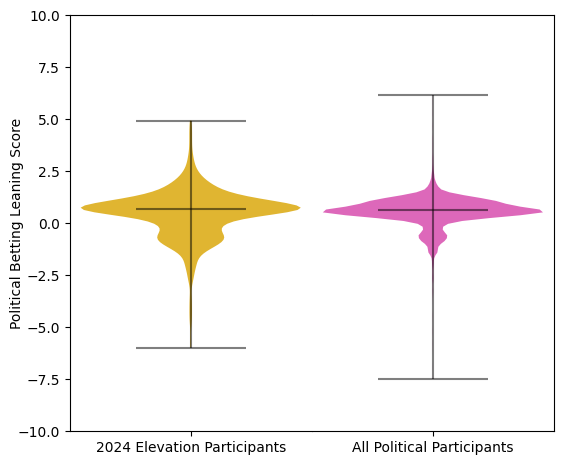

In [ ]:
valid_scores = [details["political_leaning_score"] for user, details in politics_users_profile.items() if details["political_leaning_score"] != -99]
valid_scores_800 = [details["political_leaning_score"] for user, details in politics_users_profile_800.items() if details["political_leaning_score"] != -99]

fig, axes = plt.subplots(1, 2, figsize=(6.25, 5.4))
fig.subplots_adjust(wspace=0)

# Left
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(True)
axes[0].spines['bottom'].set_visible(True)
axes[0].spines['left'].set_visible(True)
axes[0].yaxis.tick_left()
axes[0].set_ylim(-10, 10)
axes[0].set_xticks([1])
axes[0].set_xticklabels(['2024 Elevation Participants'])

# Right
axes[1].spines['left'].set_visible(False)
axes[1].spines['right'].set_visible(True)
axes[1].spines['top'].set_visible(True)
axes[1].spines['bottom'].set_visible(True)
# axes[1].yaxis.tick_right()
axes[1].set_yticks([])
axes[1].set_ylim(-10, 10)
axes[1].set_xticks([1])
axes[1].set_xticklabels(['All Political Participants'])
axes[1].yaxis.set_ticklabels([])

cmap = plt.get_cmap('coolwarm')

# 2024
parts_all = axes[0].violinplot(valid_scores_800, showmeans=False, showmedians=True)
num_parts_all = len(parts_all['bodies'])
for i, pc in enumerate(parts_all['bodies']):
    #color = cmap(1 - (i + 1) / num_parts_all)
    pc.set_facecolor(colors[0])
    pc.set_alpha(1)
for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians'):
    vp = parts_all[partname]
    vp.set_edgecolor('black')
    vp.set_alpha(0.5)
    vp.set_linewidth(1.5)

# all
parts_pol = axes[1].violinplot(valid_scores, showmeans=False, showmedians=True)
num_parts_pol = len(parts_pol['bodies'])
for i, pc in enumerate(parts_pol['bodies']):
    #color = cmap(1 - (i + 1) / num_parts_all)
    pc.set_facecolor(colors[1])
    pc.set_alpha(1)
for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians'):
    vp = parts_pol[partname]
    vp.set_edgecolor('black')
    vp.set_alpha(0.5)
    vp.set_linewidth(1.5)

# Adding the unified Y label
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel('Political Betting Leaning Score', labelpad=10)

# Save the fig
plt.savefig('./figure/PBLS_compare.pdf', format='pdf', bbox_inches='tight')

plt.show()